# What factors contribute the most to a Pokémon's popularity among viewers?

### Importing Data

In [108]:
library(tidyverse)
library(conflicted)
library(ggcorrplot)
library(randomForest)
library(caret)

conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")

pokemon <- read_csv("./pokemon_dataset.csv",
                    col_types = cols(
                                     type = col_factor(),
                                     is_legendary = col_factor()))

[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::lag over any other package.


### Exploration

In [109]:
str(pokemon)

spc_tbl_ [801 × 16] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ attack          : num [1:801] 49 62 100 52 64 104 48 63 103 30 ...
 $ capture_rate    : chr [1:801] "45" "45" "45" "45" ...
 $ defense         : num [1:801] 49 63 123 43 58 78 65 80 120 35 ...
 $ height_m        : num [1:801] 0.7 1 2 0.6 1.1 1.7 0.5 1 1.6 0.3 ...
 $ hp              : num [1:801] 45 60 80 39 58 78 44 59 79 45 ...
 $ name            : chr [1:801] "Bulbasaur" "Ivysaur" "Venusaur" "Charmander" ...
 $ percentage_male : num [1:801] 88.1 88.1 88.1 88.1 88.1 88.1 88.1 88.1 88.1 50 ...
 $ pokedex_number  : num [1:801] 1 2 3 4 5 6 7 8 9 10 ...
 $ sp_attack       : num [1:801] 65 80 122 60 80 159 50 65 135 20 ...
 $ sp_defense      : num [1:801] 65 80 120 50 65 115 64 80 115 20 ...
 $ speed           : num [1:801] 45 60 80 65 80 100 43 58 78 45 ...
 $ type            : Factor w/ 18 levels "grass","fire",..: 1 1 1 2 2 2 3 3 3 4 ...
 $ weight_kg       : num [1:801] 6.9 13 100 8.5 19 90.5 9 22.5 85.5 2.9 ...
 $ generatio

In [110]:
summary(pokemon)

     attack       capture_rate          defense          height_m     
 Min.   :  5.00   Length:801         Min.   :  5.00   Min.   : 0.100  
 1st Qu.: 55.00   Class :character   1st Qu.: 50.00   1st Qu.: 0.600  
 Median : 75.00   Mode  :character   Median : 70.00   Median : 1.000  
 Mean   : 77.86                      Mean   : 73.01   Mean   : 1.164  
 3rd Qu.:100.00                      3rd Qu.: 90.00   3rd Qu.: 1.500  
 Max.   :185.00                      Max.   :230.00   Max.   :14.500  
                                                      NA's   :20      
       hp             name           percentage_male  pokedex_number
 Min.   :  1.00   Length:801         Min.   :  0.00   Min.   :  1   
 1st Qu.: 50.00   Class :character   1st Qu.: 50.00   1st Qu.:201   
 Median : 65.00   Mode  :character   Median : 50.00   Median :401   
 Mean   : 68.96                      Mean   : 55.16   Mean   :401   
 3rd Qu.: 80.00                      3rd Qu.: 50.00   3rd Qu.:601   
 Max.   :255.00   

### Preprocessing


In [111]:
pokemon <- pokemon %>% drop_na()

pokemon <- pokemon %>%
  mutate(capture_rate = as.numeric(capture_rate))

continuous_vars <- c("attack", "defense", "height_m", "weight_kg", "hp", "speed", "sp_attack", "sp_defense",
                     "capture_rate", "percentage_male")

pokemon <- pokemon %>%
  mutate(across(all_of(continuous_vars), ~ (.-min(.)) / (max(.) - min(.))))

### Identifying Outliers

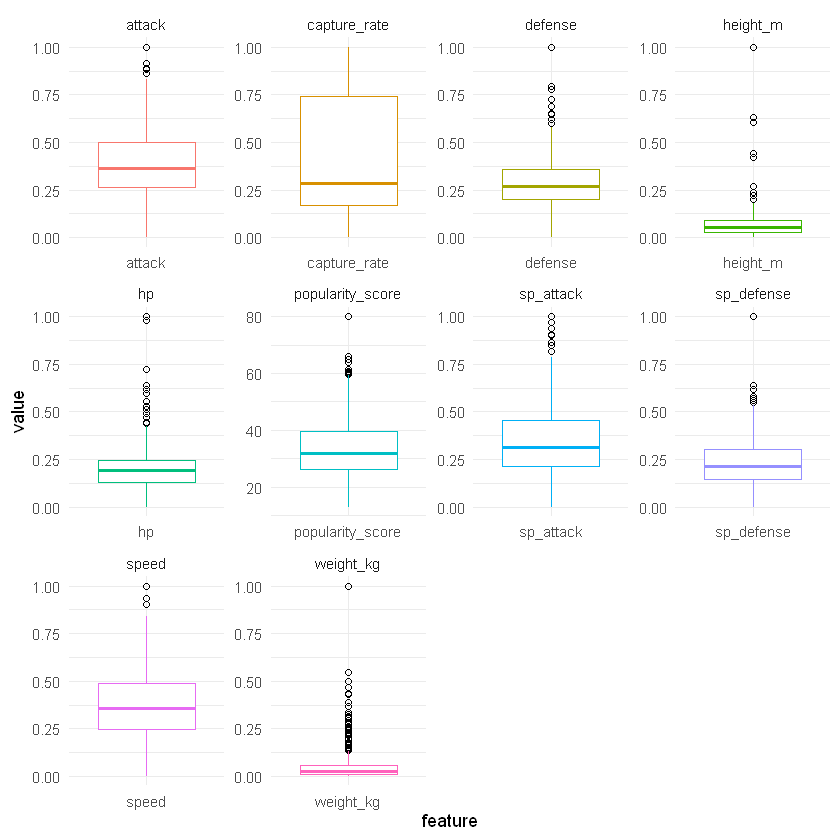

In [112]:
numerical_vars <- c("attack", "defense", "height_m", "weight_kg", "hp", "speed",
                    "sp_attack", "sp_defense", "popularity_score","capture_rate")

pokemon_pivoted <- pokemon %>%
  select(all_of(numerical_vars)) %>%
  pivot_longer(cols = everything(), names_to = "feature", values_to = "value") 

pokemon_pivoted %>%
  ggplot(aes(x = feature, y = value, color = feature)) +
  geom_boxplot(outlier.colour = "black", outlier.shape = 1) +
  facet_wrap(~feature, ncol = 4, scales = "free") +
  theme_minimal() +
  theme(legend.position = "none")

### Handling Outliers

In [113]:
cap_outliers <- function(x) {
  q1 <- quantile(x, 0.24, na.rm = TRUE)
  q3 <- quantile(x, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  outliers <- q3 + 1.5 * iqr
  x <- ifelse(x > outliers, outliers, x)
  return(x)
}

pokemon <- pokemon %>%
  mutate(across(all_of(numerical_vars), cap_outliers))

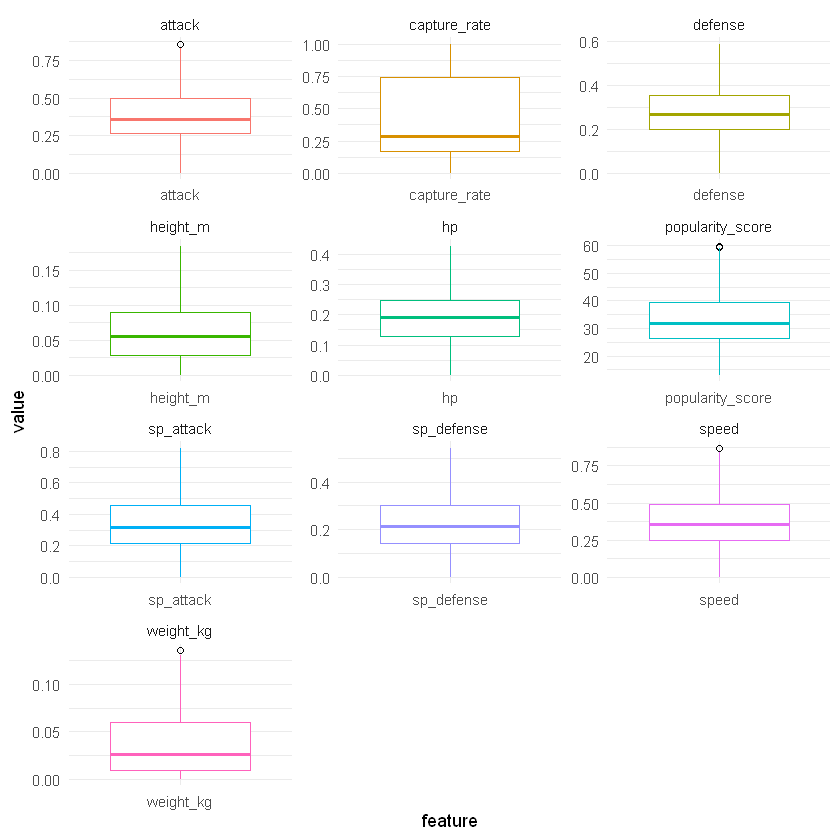

In [114]:
pokemon_pivoted <- pokemon %>%
  select(all_of(numerical_vars)) %>%
  pivot_longer(cols = everything(), names_to = "feature", values_to = "value") 

pokemon_pivoted %>%
  ggplot(aes(x = feature, y = value, color = feature)) +
  geom_boxplot(outlier.colour = "black", outlier.shape = 1) +
  facet_wrap(~feature, ncol = 3, scales = "free") +
  theme_minimal() +
  theme(legend.position = "none")

### Univariate Analysis

**Density Histogram**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


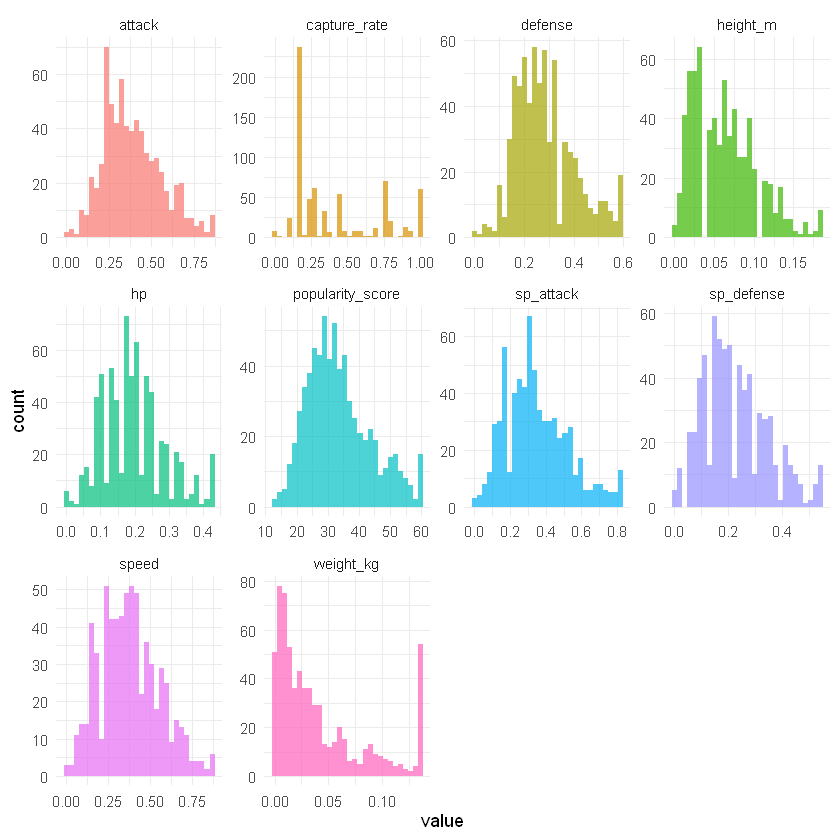

In [115]:
pokemon_pivoted %>%
  ggplot(aes(x = value, fill = feature)) +
  geom_histogram(alpha = 0.7) +
  facet_wrap(~feature, scales = "free") +
  theme_minimal() +
  theme(legend.position = "none")

**Correlation Heatmap**

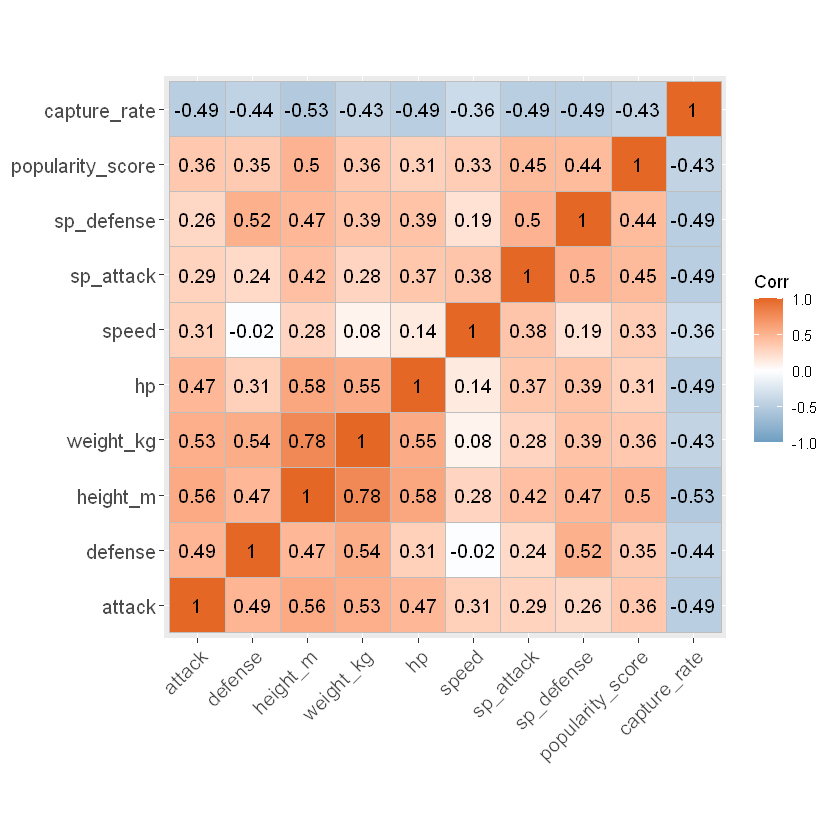

In [116]:
cor_matrix <- pokemon %>%
  select(all_of(numerical_vars)) %>%
  cor(use = "complete.obs")
  ggcorrplot(cor_matrix, lab = TRUE, ggtheme = ggplot2::theme_gray, 
             colors = c("#6D9EC1", "white", "#E46726"))

**Categorical Variable Exploration**

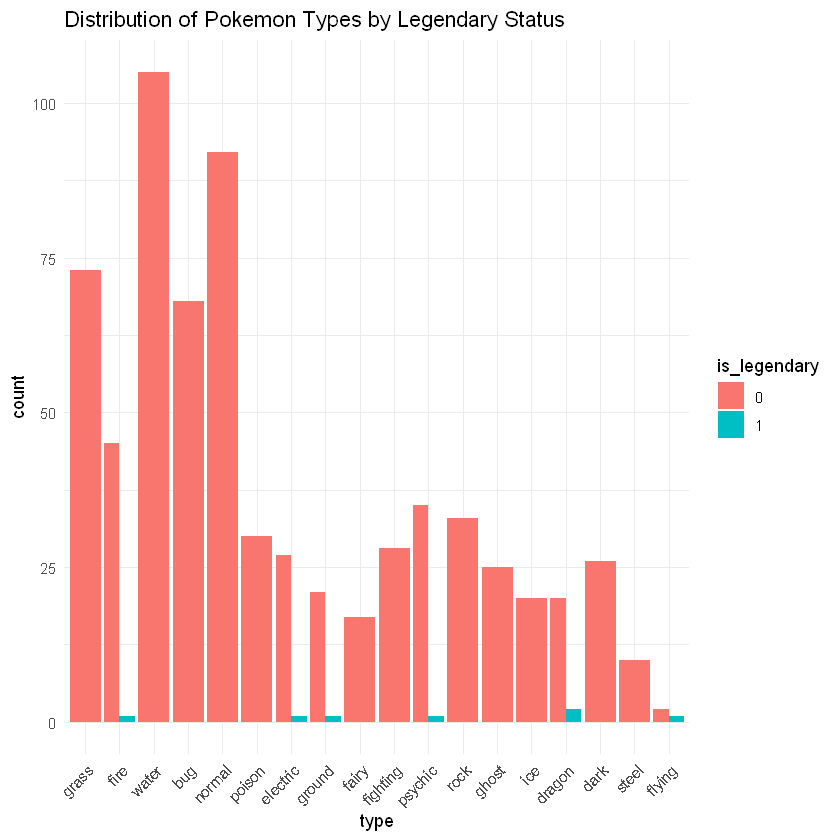

In [117]:
ggplot(pokemon, aes(x = type, fill = is_legendary)) +
  geom_bar(position = "dodge") +
  theme_minimal() +
  labs(title = "Distribution of Pokemon Types by Legendary Status") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Bivariate Analysis

**Scatter plot to visulaize correlation between all the features**

`geom_smooth()` using formula = 'y ~ x'


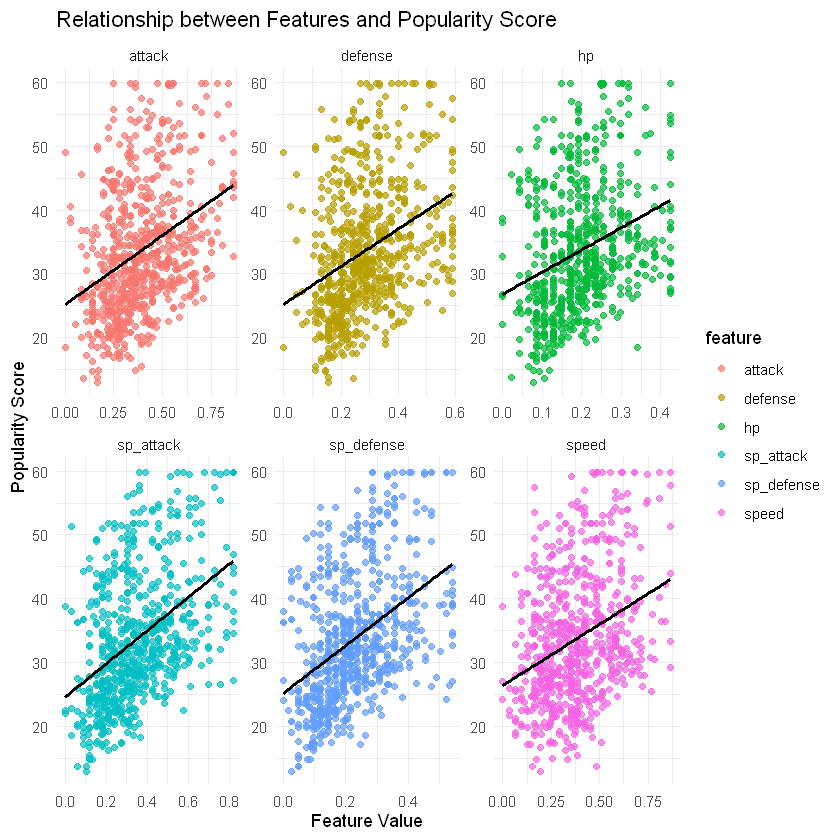

In [118]:
pokemon %>%
  select(popularity_score, attack, defense, hp, speed, sp_attack, sp_defense) %>%
  pivot_longer(cols = -popularity_score, names_to = "feature", values_to = "value") %>%
  ggplot(aes(x = value, y = popularity_score, color = feature)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE, color = "black") + 
  facet_wrap(~feature, scales = "free") +
  theme_minimal() +
  labs(title = "Relationship between Features and Popularity Score",
       x = "Feature Value", y = "Popularity Score")

**Correlation Heatmap**

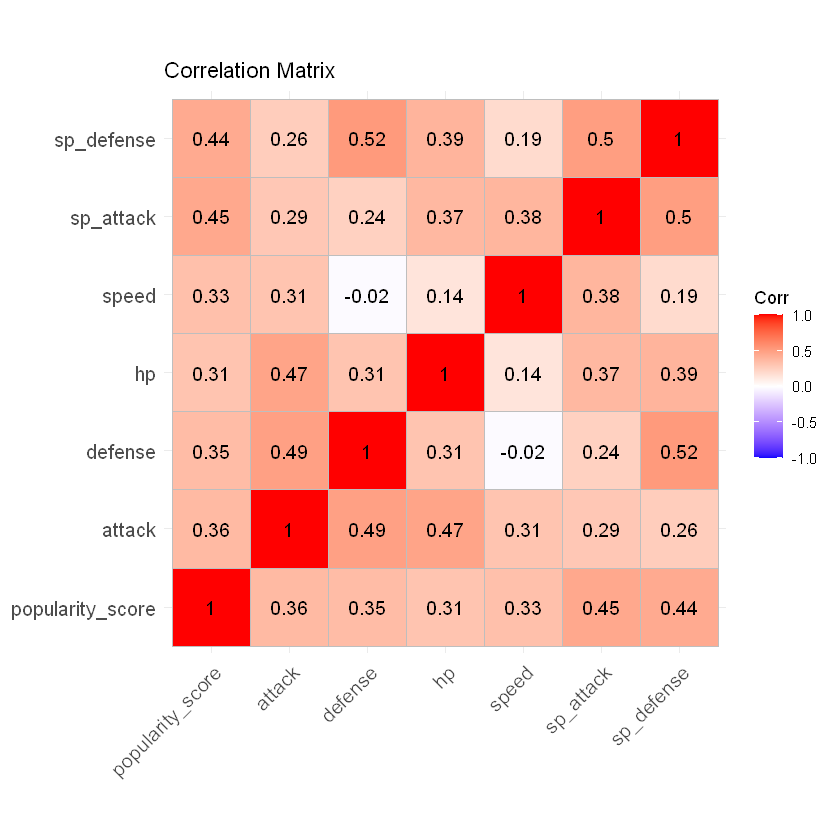

In [119]:
cor_matrix <- pokemon %>%
  select(popularity_score, attack, defense, hp, speed, sp_attack, sp_defense) %>%
  cor(use = "complete.obs")
ggcorrplot(cor_matrix, lab = TRUE, title = "Correlation Matrix")

**Boxplots for Pokemon type and ANOVA**

             Df Sum Sq Mean Sq F value  Pr(>F)    
type         17   5548   326.4   3.323 7.3e-06 ***
Residuals   666  65410    98.2                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

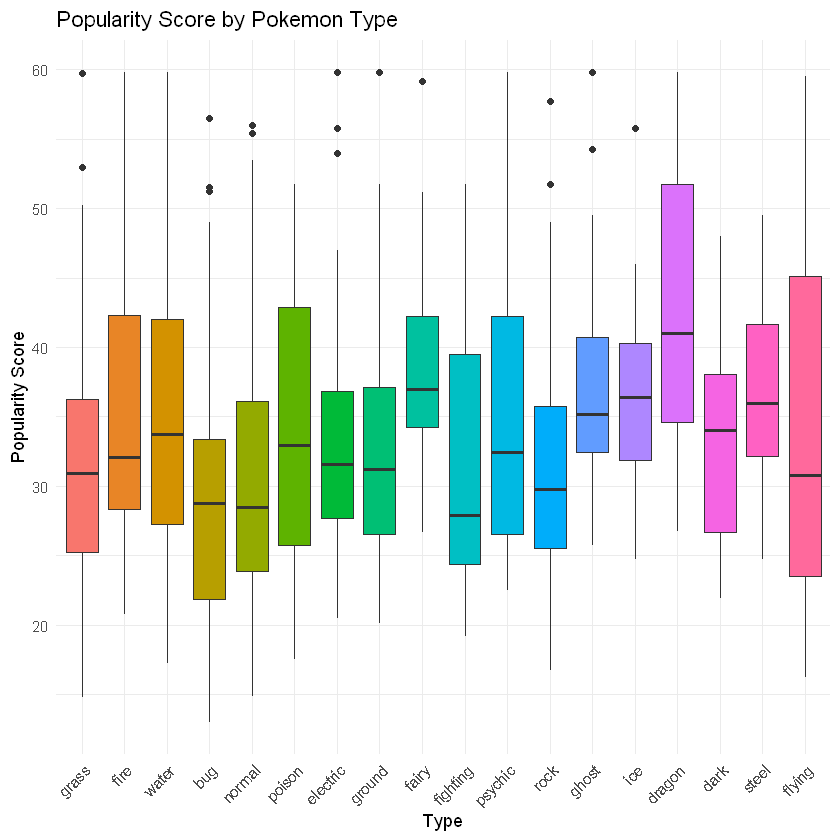

In [120]:
ggplot(pokemon, aes(x = type, y = popularity_score, fill = type)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Popularity Score by Pokemon Type", x = "Type", y = "Popularity Score") +
  theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1))

anova_result <- summary(aov(popularity_score ~ type, data = pokemon))
anova_result

In [121]:
set.seed(42)
train_index <- createDataPartition(pokemon$popularity_score, p = 0.8, list = FALSE)
train_data <- pokemon[train_index, ]
test_data <- pokemon[-train_index, ]

In [122]:
head(train_data)

attack,capture_rate,defense,height_m,hp,name,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type,weight_kg,generation,is_legendary,popularity_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
0.2444444,0.1666667,0.1955556,0.04166667,0.1063830,Bulbasaur,0.881,1,0.3333333,0.2142857,0.2580645,grass,0.007392108,1,0,44.40
0.3166667,0.1666667,0.2577778,0.06250000,0.1702128,Ivysaur,0.881,2,0.4242424,0.2857143,0.3548387,grass,0.014023263,1,0,48.75
0.5277778,0.1666667,0.5244444,0.13194444,0.2553191,Venusaur,0.881,3,0.6787879,0.4761905,0.4838710,grass,0.108598761,1,0,59.75
0.3277778,0.1666667,0.2355556,0.06944444,0.1617021,Charmeleon,0.881,5,0.4242424,0.2142857,0.4838710,fire,0.020545711,1,0,49.25
0.2388889,0.1666667,0.2666667,0.02777778,0.1021277,Squirtle,0.881,7,0.2424242,0.2095238,0.2451613,water,0.009674965,1,0,43.70
0.3222222,0.1666667,0.3333333,0.06250000,0.1659574,Wartortle,0.881,8,0.3333333,0.2857143,0.3419355,water,0.024350473,1,0,48.25


In [123]:
set.seed(42)
rf_model <- randomForest(popularity_score ~ ., data = train_data, importance = TRUE, ntree = 500)

importance <- importance(rf_model)
importance_df <- data.frame(Feature = rownames(importance), Importance = importance[, -1]) %>%
  arrange(desc(Importance))

importance

,%IncMSE,IncNodePurity
attack,17.348353,1609.3143
capture_rate,21.132530,4446.5900
defense,19.152876,1608.2802
height_m,21.041864,5217.0118
hp,16.528952,1207.9441
name,-1.544987,364.4784
percentage_male,4.059600,220.4828
pokedex_number,31.613634,15551.2255
sp_attack,23.502424,2467.1610
sp_defense,23.629688,3705.8160


In [124]:
importance_df

,Feature,Importance
,<chr>,<dbl>
pokedex_number,pokedex_number,15551.2255
generation,generation,12624.1765
height_m,height_m,5217.0118
capture_rate,capture_rate,4446.5900
sp_defense,sp_defense,3705.8160
type,type,3294.2597
sp_attack,sp_attack,2467.1610
is_legendary,is_legendary,1795.1904
attack,attack,1609.3143


In [125]:
predictions_rf <- predict(rf_model, newdata = test_data)
mse_rf <- mean((predictions_rf - actuals)^2)
cat("Mean Squared Error (Random Forest):", mse_rf)

ERROR: Error: object 'actuals' not found


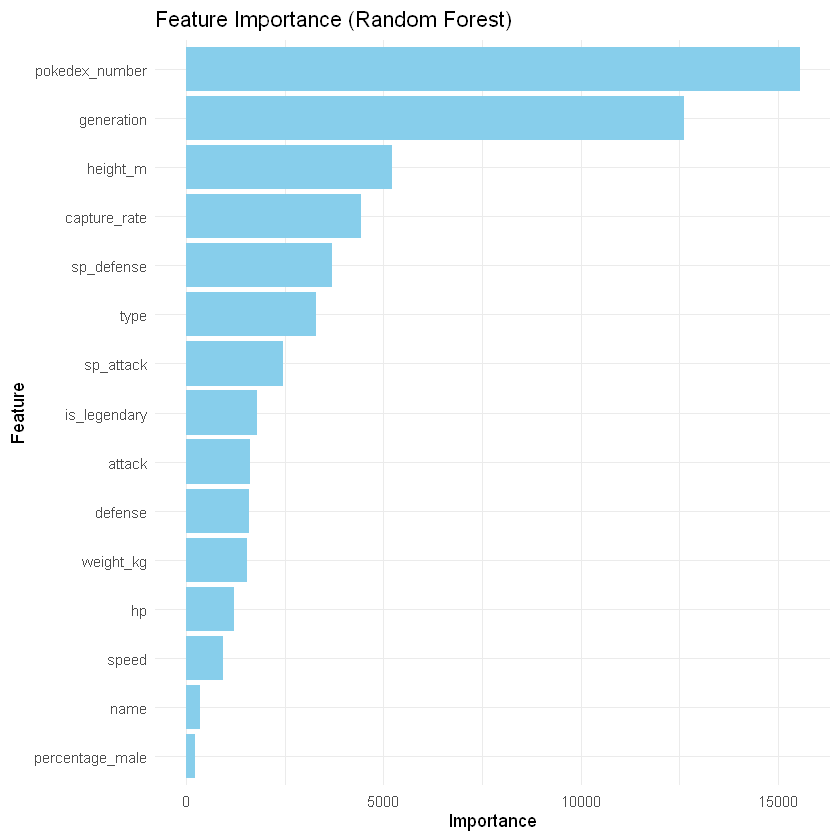

In [106]:
ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  coord_flip() +
  theme_minimal() +
  labs(title = "Feature Importance (Random Forest)", x = "Feature", y = "Importance")

In [126]:
library(pdp)
pdp_plot <- partial(rf_model, pred.var = "attack")
autoplot(pdp_plot) +
  theme_minimal() +
  labs(title = "Partial Dependence Plot: Attack vs Popularity Score")

ERROR: Error in library(package, pos = pos, lib.loc = lib.loc, character.only = TRUE, : there is no package called 'pdp'


In [127]:
# Normalize feature importance to show relative contribution
importance_df <- importance_df %>%
  mutate(Relative_Contribution = (Importance / sum(Importance)) * 100)

# Top 10 features by importance
top_features <- importance_df %>%
  arrange(desc(Relative_Contribution)) %>%
  head(10)

print(top_features)


                      Feature Importance Relative_Contribution
pokedex_number pokedex_number  15551.226             27.474230
generation         generation  12624.177             22.303035
height_m             height_m   5217.012              9.216854
capture_rate     capture_rate   4446.590              7.855756
sp_defense         sp_defense   3705.816              6.547037
type                     type   3294.260              5.819943
sp_attack           sp_attack   2467.161              4.358714
is_legendary     is_legendary   1795.190              3.171549
attack                 attack   1609.314              2.843163
defense               defense   1608.280              2.841336


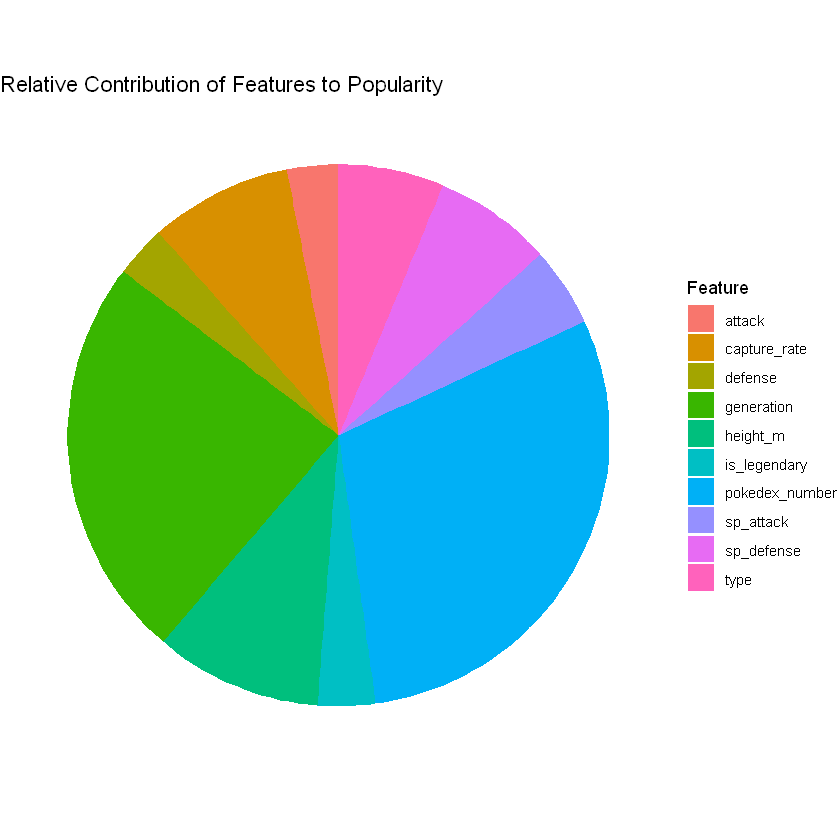

In [128]:
ggplot(top_features, aes(x = "", y = Relative_Contribution, fill = Feature)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  theme_void() +
  labs(title = "Relative Contribution of Features to Popularity",
       fill = "Feature")

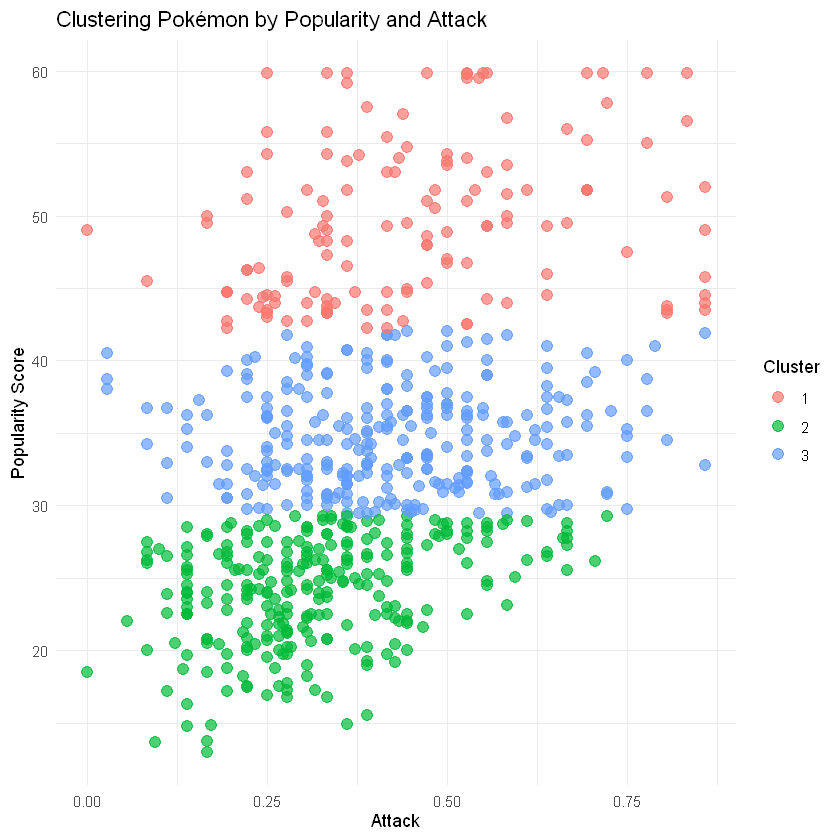

In [130]:
# K-means clustering on popularity_score and key features
set.seed(123)
cluster_data <- pokemon_encoded %>%
  select(popularity_score, attack, defense, speed, sp_attack)

kmeans_result <- kmeans(cluster_data, centers = 3)  # Choose 3 clusters
pokemon$Cluster <- as.factor(kmeans_result$cluster)

# Visualize clusters using a scatter plot
ggplot(pokemon, aes(x = attack, y = popularity_score, color = Cluster)) +
  geom_point(size = 3, alpha = 0.7) +
  theme_minimal() +
  labs(title = "Clustering Pokémon by Popularity and Attack",
       x = "Attack", y = "Popularity Score", color = "Cluster")
